## Visualise fitting results 

In [1]:
include("main_utils.jl")
include("fit_utils.jl")

default_plot_setting()

Plots.GRBackend()

In [2]:
df_dds = CSV.read("../dt_surveys_master/master_dds.csv", DataFrame);

### Basic stats check

In [3]:
println("Check max daly number of contacts")
tab = @pipe groupby(df_dds, [:key, :strat]) |> combine(_, :x => maximum => :max_cnt)
unstack(tab, :key, :strat, :max_cnt)

Check max daly number of contacts


Row,key,all,home,non-home
,String31,Int64?,Int64?,Int64?
1,CoMix_uk_internal,9001,24,9000
2,Leon_2013,3011,20,3009
3,Leon_2013_post,1169,20,1169
4,Leon_2013_online,3011,13,3009


In [4]:
println("Check sample size")
tab = @pipe groupby(df_dds, [:key, :strat]) |> combine(_, :y => sum => :n_part)
unstack(tab, :key, :strat, :n_part)

Check sample size


Row,key,all,home,non-home
,String31,Int64?,Int64?,Int64?
1,CoMix_uk_internal,88965,88965,88965
2,Leon_2013,5200,5200,5200
3,Leon_2013_post,3783,3783,3783
4,Leon_2013_online,1417,1417,1417


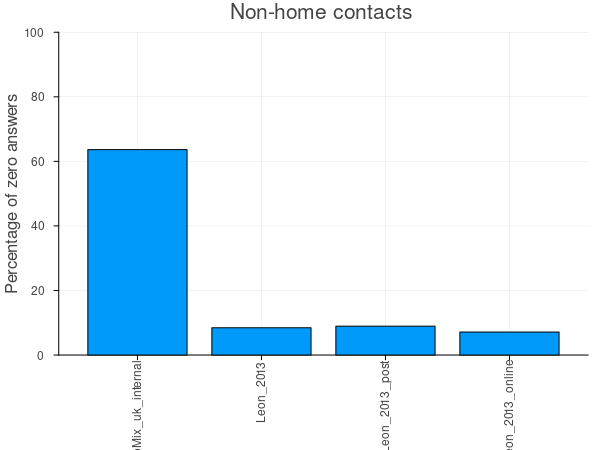

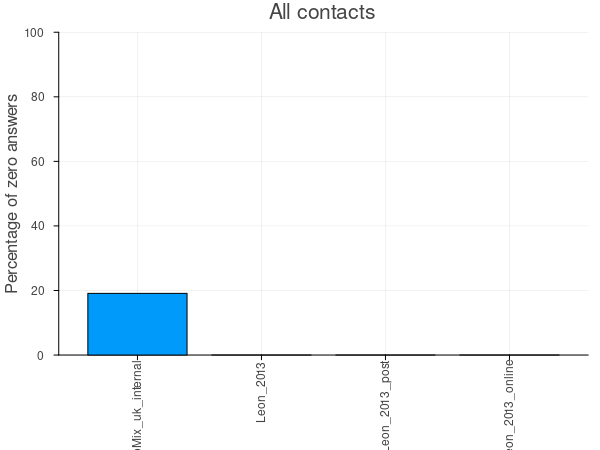

In [5]:
include("fit_utils.jl")
plot_zero_pct(df_dds)

# Create summary stats from fitting results

In [6]:
include("main_utils.jl")
include("fit_utils.jl")

get_median_parms_from_model

In [8]:
include("main_utils.jl")
include("fit_utils.jl")
# df_sum = DataFrame()
# s_keys = ["Grijalva_2015", "Hens_2009", "Horby_2011", "Kassteele_2017"]
# for k in s_keys
#     df_sum = vcat(df_sum, create_summary_stat_one_data(k))
# end
#CSV.write("../dt_intermediate/fit_summary.csv", df_sum)
df_sum = CSV.read("../dt_intermediate/fit_summary.csv", DataFrame)
df_res = flag_minimum_IC(df_sum, :waic);
df_res = @subset(df_res, :key .!=  "Litvinova_2019");
df_res = @subset(df_res, :key .!=  "Vanhoek_2013");

In [9]:
df_obs = @pipe groupby(df_dds, [:key, :strat]) |>
    combine(_, :y => sum => :n_answer);

In [10]:
include("fit_utils.jl")
df_obs_all = @subset(df_obs, :strat .== "all")
df_EVI = read_EVI_summary(df_obs)
df_EVI = @subset(df_EVI, .~in.(:key, Ref(["Vanhoek_2013", "Litvinova_2019"])));

### Mean comparison

In [11]:

include("main_utils.jl")
include("fit_utils.jl")

get_median_parms_from_model

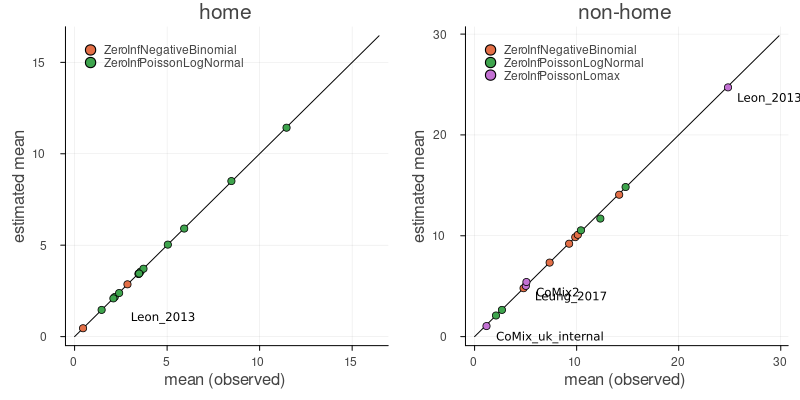

In [12]:
obs_estimated_validation_plot(df_res)

# WAIC weights

In [13]:
include("main_utils.jl")
include("fit_utils.jl")
model_names = get_model_names()

3-element Vector{String}:
 "ZeroInfNegativeBinomial"
 "ZeroInfPoissonLogNormal"
 "ZeroInfPoissonLomax"

In [14]:
df_ana = prep_fmnl_vars(df_res)
sort!(df_ana, :n_sample)
ytk = df_ana[:, :key_pri];

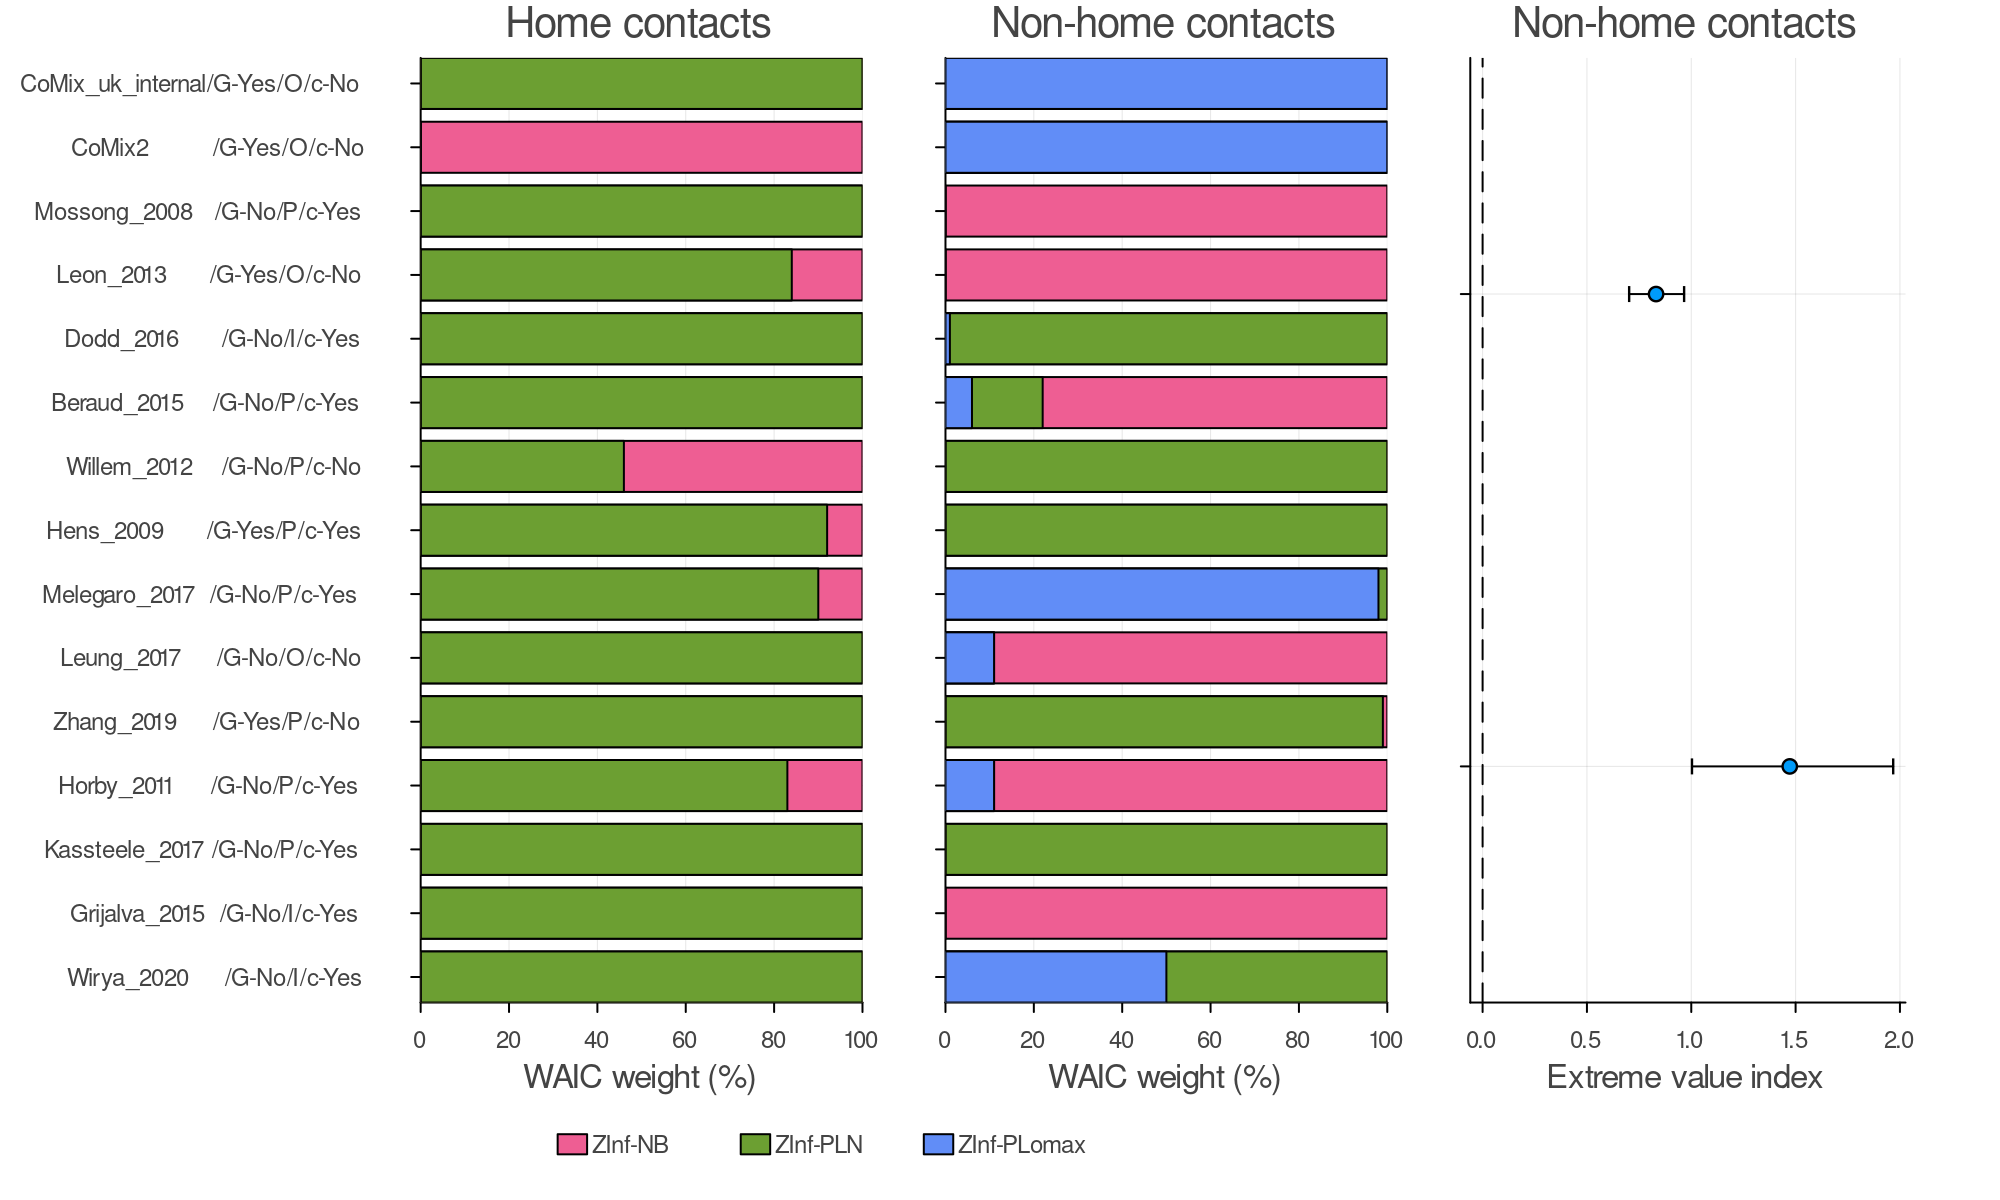

In [15]:
df_EVI_nhm = @subset(df_EVI, :strat .== "non-home");
plot_bar_waic(df_obs, df_res; ytk = ytk, df_EVI=df_EVI_nhm)

## Fractional multinomial regression for meta-regression

In [16]:
include("main_utils.jl")

calculate_fmnl_probs (generic function with 1 method)

In [17]:
df_ana = prep_fmnl_vars(df_res)
@select(df_ana, Not(model_names)) |> display

Row,key,n_sample,logX,group_c,mode,cutoff_less90,key_pri,mode_cate
,String31,Int64?,Float64,Any,String,String,String,Cat…
1,Mossong_2008,7290,3.86273,G-No,P,c-Yes,Mossong_2008 /G-No/P/c-Yes,P
2,Hens_2009,1500,3.17609,G-Yes,P,c-Yes,Hens_2009 /G-Yes/P/c-Yes,P
3,Grijalva_2015,595,2.77452,G-No,I,c-Yes,Grijalva_2015 /G-No/I/c-Yes,I
4,Melegaro_2017,1158,3.06371,G-No,P,c-Yes,Melegaro_2017 /G-No/P/c-Yes,P
5,Beraud_2015,3510,3.54531,G-No,P,c-Yes,Beraud_2015 /G-No/P/c-Yes,P
6,Leung_2017,1149,3.06032,G-No,O,c-No,Leung_2017 /G-No/O/c-No,O
7,Horby_2011,865,2.93702,G-No,P,c-Yes,Horby_2011 /G-No/P/c-Yes,P
8,Dodd_2016,3576,3.5534,G-No,I,c-Yes,Dodd_2016 /G-No/I/c-Yes,I
9,Zhang_2019,965,2.98453,G-Yes,P,c-No,Zhang_2019 /G-Yes/P/c-No,P


In [18]:
include("main_utils.jl")
pred, Y, x_names = one_hot_encoding_multi_vars(df_ana);
@time chn = sample(model_fmnl(pred, Y), NUTS(), 2000; progress = true)

FormulaTerm
Response:
  y_dummy(continuous)
Predictors:
  1
  (n_sample)->log10(n_sample)
  group_c(DummyCoding:2→1)
  mode_cate(DummyCoding:3→2)
  cutoff_less90(DummyCoding:2→1)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /opt/julia/packages/Turing/gtb9I/src/mcmc/hmc.jl:216
Sampling   0%|▎                                         |  ETA: 1:14:35
Sampling   1%|▍                                         |  ETA: 0:37:21
Sampling   2%|▋                                         |  ETA: 0:24:53
Sampling   2%|▉                                         |  ETA: 0:18:38
Sampling   2%|█                                         |  ETA: 0:14:54
Sampling   3%|█▎                                        |  ETA: 0:12:23
Sampling   4%|█▌                                        |  ETA: 0:10:36
Sampling   4%|█▋                                        |  ETA: 0:09:16
Sampling   4%|█▉                                        |  ETA: 0:08:12
Sampling   5%|██▏                                       |  ETA: 0:07:21
Sampling   6%|██▎                                       |  ETA: 0:06:40
Sampling   6%|██▌     

 58.538417 seconds (65.36 M allocations: 7.542 GiB, 6.16% gc time, 80.73% compilation time)


Chains MCMC chain (2000×26×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 36.1 seconds
Compute duration  = 36.1 seconds
parameters        = β1[1], β1[2], β1[3], β1[4], β1[5], β1[6], β2[1], β2[2], β2[3], β2[4], β2[5], β2[6]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [19]:
#explore_chns(chn)

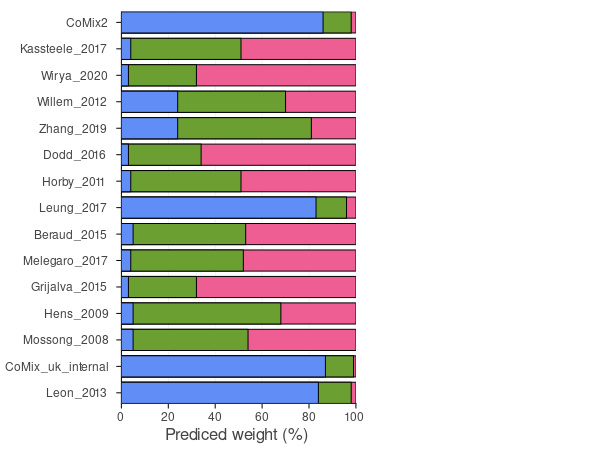

In [20]:
include("main_utils.jl")
df_pred_cum = pred_fmnl_multi_vars(chn, pred)
plot_stacked_bar(df_pred_cum, model_names; xlabel="Prediced weight (%)")

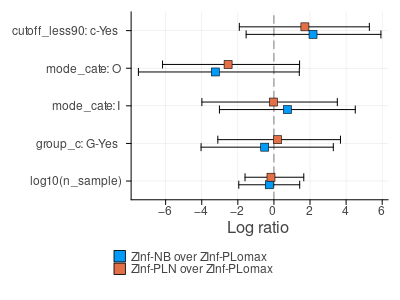

In [21]:
include("main_utils.jl")
# TODO: delete this part in the future
chn_res_multi = extract_chain_info(chn)
n_x = size(pred, 2)
forestplot_fmnl_multi_vars(chn_res_multi[Not([1, n_x+1]), :], x_names[2:end])

In [22]:
include("main_utils.jl")
include("fit_utils.jl")
chn_res = repeated_univariate_fmnl_reg(df_ana);

FormulaTerm
Response:
  y_dummy(continuous)
Predictors:
  1
  (n_sample)->log10(n_sample)
  group_c(DummyCoding:2→1)
  mode_cate(DummyCoding:3→2)
  cutoff_less90(DummyCoding:2→1)

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /opt/julia/packages/Turing/gtb9I/src/mcmc/hmc.jl:216
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /opt/julia/packages/Turing/gtb9I/src/mcmc/hmc.jl:216
┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /opt/julia/packages/Turing/gtb9I/src/mcmc/hmc.jl:216
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /opt/julia/packages/Turing/gtb9I/src/mcmc/hmc.jl:216


┌ Warning: n° of legend_column=3 is larger than n° of series=2
└ @ Plots /opt/julia/packages/Plots/8ZnR3/src/backends/gr.jl:1238
┌ Warning: n° of legend_column=3 is larger than n° of series=2
└ @ Plots /opt/julia/packages/Plots/8ZnR3/src/backends/gr.jl:1238
┌ Warning: n° of legend_column=3 is larger than n° of series=2
└ @ Plots /opt/julia/packages/Plots/8ZnR3/src/backends/gr.jl:1238


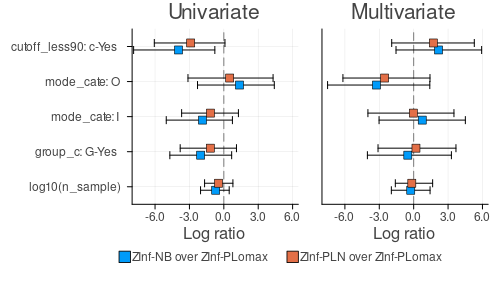

In [23]:
include("fit_utils.jl")
plot_meta_reg(chn_res, chn_res_multi)